<a href="https://colab.research.google.com/github/md-zihad/3200-Lab/blob/main/BERT_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets accelerate
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset

# Check CUDA availability
assert torch.cuda.is_available(), "Enable GPU in Colab (Runtime → Change runtime type)"
print("GPU:", torch.cuda.get_device_name(0))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Load a small subset for quick benchmarking
dataset = load_dataset("imdb")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Use tiny subsets for faster benchmarking
train_dataset = dataset["train"].shuffle(seed=42).select(range(500)).map(tokenize, batched=True)
eval_dataset = dataset["test"].shuffle(seed=42).select(range(100)).map(tokenize, batched=True)
train_dataset = train_dataset.rename_column("label", "labels")
eval_dataset = eval_dataset.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [3]:
def benchmark_bert_training(use_optimizations=True):
    # Reset model and seeds for fair comparison
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to("cuda")
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)

    # Training arguments configuration
    batch_size = 32 if use_optimizations else 8  # Larger batches with optimizations
    args = TrainingArguments(
        output_dir="./benchmark",
        num_train_epochs=2,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        fp16=use_optimizations,  # Enable mixed precision only for optimized run
        gradient_accumulation_steps=1,
        learning_rate=2e-5,
        logging_steps=0,  # Disable logging to reduce overhead
        evaluation_strategy="no",  # Disable evaluation during training
        save_strategy="no",
        dataloader_pin_memory=use_optimizations,  # Faster data transfers
        report_to="none",
        seed=42,
        torch_compile=False,  # Disable for stability in Colab
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
    )

    # Time training
    start_time = time.time()
    trainer.train()
    elapsed_time = time.time() - start_time

    return elapsed_time

In [6]:
!pip install transformers datasets accelerate
import torch
import time
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset

# Verify CUDA
assert torch.cuda.is_available(), "Enable GPU in Colab!"
print("GPU:", torch.cuda.get_device_name(0))

# Load dataset
dataset = load_dataset("imdb")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# Small subset for quick testing
train_dataset = dataset["train"].shuffle(seed=42).select(range(500)).map(tokenize, batched=True)
train_dataset = train_dataset.rename_column("label", "labels")

def benchmark_bert_training(use_optimizations=True):
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to("cuda")
    torch.manual_seed(42)
    torch.cuda.manual_seed_all(42)

    # Updated TrainingArguments for Colab compatibility
    args = TrainingArguments(
        output_dir="./benchmark",
        num_train_epochs=2,
        per_device_train_batch_size=32 if use_optimizations else 8,
        learning_rate=2e-5,
        fp16=use_optimizations,  # FP16 mixed precision
        logging_steps=10,
        eval_strategy="no",  # Correct argument name for older Transformers versions
        save_strategy="no",
        report_to="none",
        seed=42,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
    )

    start_time = time.time()
    trainer.train()
    return time.time() - start_time

# Run benchmarks
print("=== Baseline (No CUDA Optimizations) ===")
time_baseline = benchmark_bert_training(use_optimizations=False)

print("\n=== CUDA Optimized ===")
time_optimized = benchmark_bert_training(use_optimizations=True)

# Results
print(f"\nBaseline Time: {time_baseline:.2f}s")
print(f"Optimized Time: {time_optimized:.2f}s")
print(f"Speedup: {time_baseline/time_optimized:.1f}x")

GPU: Tesla T4
=== Baseline (No CUDA Optimizations) ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.704400
20,0.679200
30,0.689600
40,0.671800
50,0.643100
60,0.593300
70,0.542900
80,0.555800
90,0.437200
100,0.435100



=== CUDA Optimized ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.682500
20,0.650300
30,0.596500



Baseline Time: 26.22s
Optimized Time: 7.01s
Speedup: 3.7x



=== Benchmark Results ===
Baseline (FP32, batch=8): 26.22 seconds
Optimized (FP16, batch=32): 7.01 seconds
Speedup: 3.7x


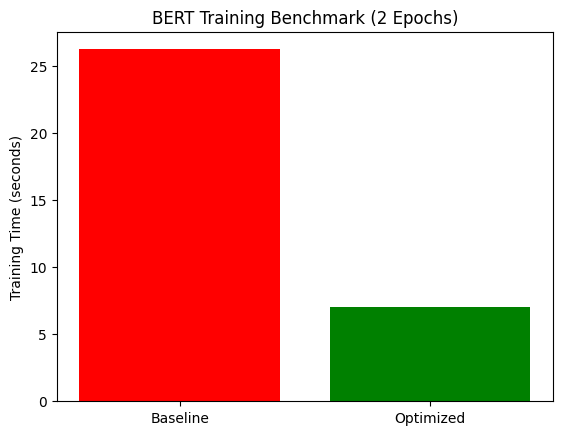

In [7]:
# Calculate speedup
speedup = time_baseline / time_optimized

# Print comparison table
print("\n=== Benchmark Results ===")
print(f"Baseline (FP32, batch=8): {time_baseline:.2f} seconds")
print(f"Optimized (FP16, batch=32): {time_optimized:.2f} seconds")
print(f"Speedup: {speedup:.1f}x")

# Optional: Plot results
import matplotlib.pyplot as plt
plt.bar(["Baseline", "Optimized"], [time_baseline, time_optimized], color=["red", "green"])
plt.ylabel("Training Time (seconds)")
plt.title("BERT Training Benchmark (2 Epochs)")
plt.show()